In [1]:
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import least_squares, minimize

import archimedes as arc
from archimedes import tree
from archimedes.experimental.sysid import make_pem
from archimedes.experimental.discretize import discretize

from cartpole import CartPole

%load_ext autoreload
%autoreload 2

In [2]:
# Dynamics function
system = CartPole()

x0 = np.array([0.0, 3.0, 0.0, 0.0])  # Initial state

t0, tf = 0.0, 20.0

u0 = np.array([0.0])
dt = 0.001
ts = np.arange(t0, tf, dt)


def f(t, x):
    return system.dynamics(t, x, u0)


xs_true = arc.odeint(f, x0=x0, t_span=(t0, tf), t_eval=ts, rtol=1e-6, atol=1e-8)
# xs = np.zeros((len(ts), 4))
# xs[0] = x0
# for i in range(1, len(ts)):
#     xs[i] = f(ts[i-1], xs[i-1], us[i])

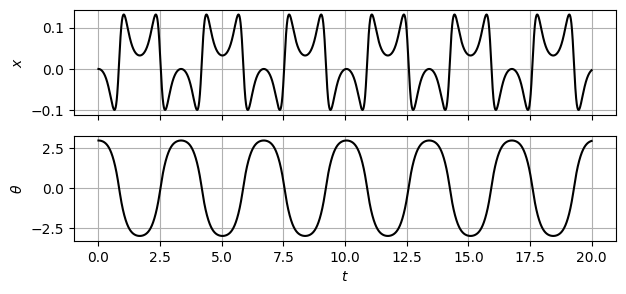

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [4]:
params_guess = {
    "m1": 0.5,
    "m2": 0.5,
    "L": 1.0,
}

x0_guess = np.array([0.0, 3.0, 0.0, 0.0])

# Optimize the initial condition and parameters
# dvs_guess = x0_guess, params_guess
dvs_guess = params_guess
dvs_guess_flat, unravel = tree.ravel(dvs_guess)

In [5]:
@arc.compile(kind="MX", static_argnames=("fwd",))
def residuals(fwd, dvs_guess_flat):
    xs_pred = fwd(dvs_guess_flat)
    return xs_true - xs_pred

# Shooting

In [6]:
def ode_rhs(t, x, params):
    model = system.replace(**params)
    return model.dynamics(t, x, u0)


@arc.compile
def fwd_shoot(dvs_flat):
    params = unravel(dvs_flat)

    f = arc.compile(ode_rhs)
    xs_pred = arc.odeint(
        f, x0=x0, t_span=(t0, tf), args=(params,), t_eval=ts, rtol=1e-6, atol=1e-8
    )
    return xs_pred


xs_pred = fwd_shoot(dvs_guess_flat)

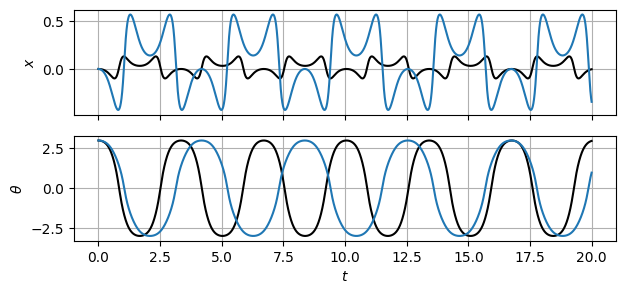

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [8]:
residuals(fwd_shoot, dvs_guess_flat)

array([[ 0.00000000e+00,  4.68182375e-07,  1.87100578e-06, ...,
         3.37775120e-01,  3.39528883e-01,  3.41261695e-01],
       [ 0.00000000e+00, -4.35924277e-07, -1.73159744e-06, ...,
         2.00509275e+00,  1.99953064e+00,  1.99398392e+00],
       [ 0.00000000e+00,  9.35056742e-04,  1.87012773e-03, ...,
         1.76428004e+00,  1.74326628e+00,  1.72237784e+00],
       [ 0.00000000e+00, -8.63328814e-04, -1.72669794e-03, ...,
        -5.56984806e+00, -5.55438907e+00, -5.53905752e+00]],
      shape=(4, 20000))

In [9]:
@arc.compile
def obj_shoot(dvs_guess_flat):
    r = residuals(fwd_shoot, dvs_guess_flat)
    r_norm = np.sum(r**2, axis=0)
    xs_norm = np.sum(xs_true**2, axis=0)
    return np.sum(r_norm / xs_norm)


obj_shoot(dvs_guess_flat)

array(43683.9504611)

In [10]:
# def callback(intermediate_result):
#     print(intermediate_result.fun, intermediate_result.x)

# bounds = [(0.0, np.inf) for _ in range(len(dvs_guess_flat))]

# minimize(
#     obj_shoot,
#     dvs_guess_flat,
#     # method="L-BFGS-B",
#     method="trust-constr",
#     jac=arc.jac(obj_shoot),
#     hess=arc.hess(obj_shoot),
#     options={"disp": True},
#     bounds=bounds,
#     callback=callback,
# )

In [11]:
# arc.minimize(obj_shoot, dvs_guess_flat)

# Set up PEM

In [12]:
# Discretize with RK4
dyn = discretize(ode_rhs, dt, method="rk4")


def obs(t, x, dvs_flat):
    return x

In [13]:
nx, ny = 4, 4
Q = np.eye(nx)
R = 1e4 * np.eye(ny)

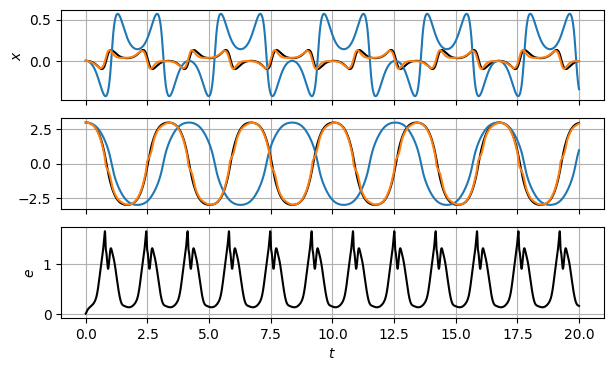

In [14]:
kf_fwd = make_pem(
    dyn,
    obs,
    ts,
    xs_true,
    Q=Q,
    R=R,
)

args = (params_guess,)
x_hat, e, _, _, _ = kf_fwd(x0, args)

fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, x_hat[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, x_hat[1])
ax[1].grid()
ax[2].set_ylabel(r"$\theta$")
ax[2].plot(ts, np.linalg.norm(e, axis=0), c="k")
ax[2].grid()
ax[2].set_ylabel(r"$e$")
ax[-1].set_xlabel(r"$t$")

plt.show()

# NLP solver

In [15]:
@arc.compile
def obj_pem(dvs_flat):
    params = unravel(dvs_flat)
    x_hat, e, _, _, _ = kf_fwd(x0, (params,))
    return np.sum(e.flatten() ** 2) / len(e.flatten())


obj_pem(dvs_guess_flat)

array(0.15551019)

In [16]:
arc.jac(obj_pem)(dvs_guess_flat)

array([ 0.30857759, -0.27066048,  0.27066048])

In [17]:
@arc.compile
def obj_pem(dvs_flat):
    params = unravel(dvs_flat)
    x_hat, e, J, _, _ = kf_fwd(x0, (params,))
    return J

obj_pem(dvs_guess_flat)

array(0.62204076)

In [18]:
arc.jac(obj_pem)(dvs_guess_flat)

array([ 1.23431038, -1.08264192,  1.08264192])

In [19]:
def callback(intermediate_result):
    print(intermediate_result.fun, intermediate_result.x)


sol = minimize(
    obj_pem,
    dvs_guess_flat,
    method="BFGS",
    # method="trust-exact",
    jac=arc.jac(obj_pem),
    # hess=arc.hess(obj_pem),
    options={"disp": True},
    callback=callback,
)
dvs_opt_flat = sol.x  # About 2:16

0.128974545342852 [ 0.36610605  1.05600291 -0.05600291]
0.1063959489943302 [0.65995751 1.24331691 0.14395541]
0.06872966322360945 [0.64227425 1.25905651 0.22551651]
0.010529733286265225 [0.54339334 1.22788022 0.29132706]
0.001282918733543389 [0.50082636 1.2096146  0.3133557 ]
0.0003163947795344033 [0.49422707 1.20129872 0.3363541 ]
1.712390822356492e-05 [0.49813593 1.19733746 0.35458522]
5.935468172157389e-08 [0.49994868 1.19663359 0.35901644]
4.903208530811279e-08 [0.49999836 1.19665794 0.35900181]
4.898945309314322e-08 [0.50000072 1.19666044 0.35899697]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


In [20]:
# Simulate forward with optimal parameters
xs_opt = fwd_shoot(dvs_opt_flat)

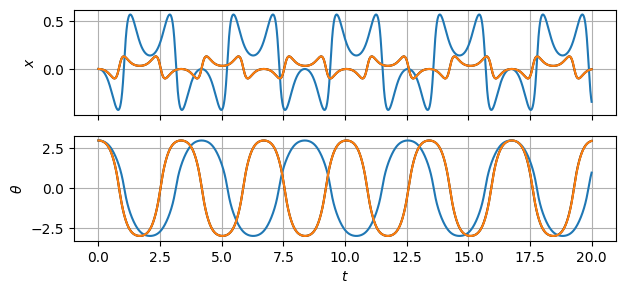

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

# Least-squares optimization

In [25]:
from archimedes.experimental.sysid import lm_solve

@arc.compile
def pem_func(dvs_flat):
    params = unravel(dvs_flat)
    _, _, V, g, H = kf_fwd(x0, (params,))
    return V, g, H


pem_func(dvs_guess_flat)

[array(0.62204076),
 array([ 0.0070804 , -0.00991725,  0.00991725]),
 array([[ 0.00019608, -0.00016203,  0.00016203],
        [-0.00016203,  0.0005702 , -0.0005702 ],
        [ 0.00016203, -0.0005702 ,  0.0005702 ]])]

In [26]:
result = lm_solve(
    pem_func,
    dvs_guess_flat,
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    nprint=1,
)

print(result)

Iteration 0, Cost: 0.6220407625715891, Grad norm: 0.00991724923746325
Iteration 1, Cost: 0.006084370044876186, Grad norm: 0.001989898225819927
Iteration 2, Cost: 0.004282364358516347, Grad norm: 0.0012771935832899227
Iteration 3, Cost: 0.0006097475477702091, Grad norm: 0.000468672635843121
Iteration 4, Cost: 0.0001827578484719077, Grad norm: 0.00023845541089746405
Iteration 5, Cost: 6.413497271154362e-05, Grad norm: 0.00012343000466405113
Iteration 6, Cost: 3.988119370451046e-05, Grad norm: 8.13137408074257e-05
LMResult(x=array([0.50181176, 0.75894984, 0.23327033]), success=True, status=4, message='The cosine of the angle between fvec and any column of the Jacobian is at most gtol in absolute value', fun=array(3.98811937e-05), jac=array([ 3.19858767e-05, -2.49925385e-05,  8.13137408e-05]), hess=array([[ 6.72032581e-04,  3.48182918e-05, -1.13282032e-04],
       [ 3.48182918e-05,  3.79178106e-05, -1.23366381e-04],
       [-1.13282032e-04, -1.23366381e-04,  4.01375071e-04]]), nfev=18, nje

In [27]:
# Simulate forward with optimal parameters
dvs_opt_flat = result.x
xs_opt = fwd_shoot(dvs_opt_flat)

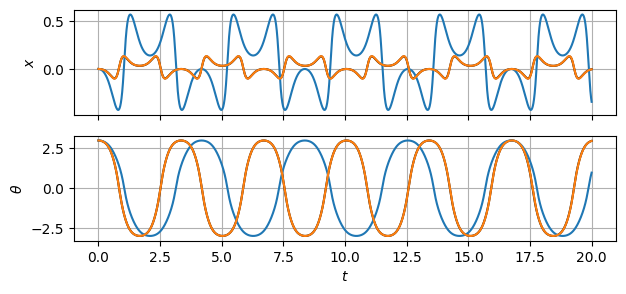

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()